In [1]:
from scipy.stats import vonmises,skewnorm
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from tqdm import tqdm
import numpy as np
import ot

from lcot import LCOT
from lcot.measures import measure,empirical_measure,ot_1d
from lcot.visualize import plot_circle_pdf

import warnings
warnings.filterwarnings("ignore")

## Experiment 1

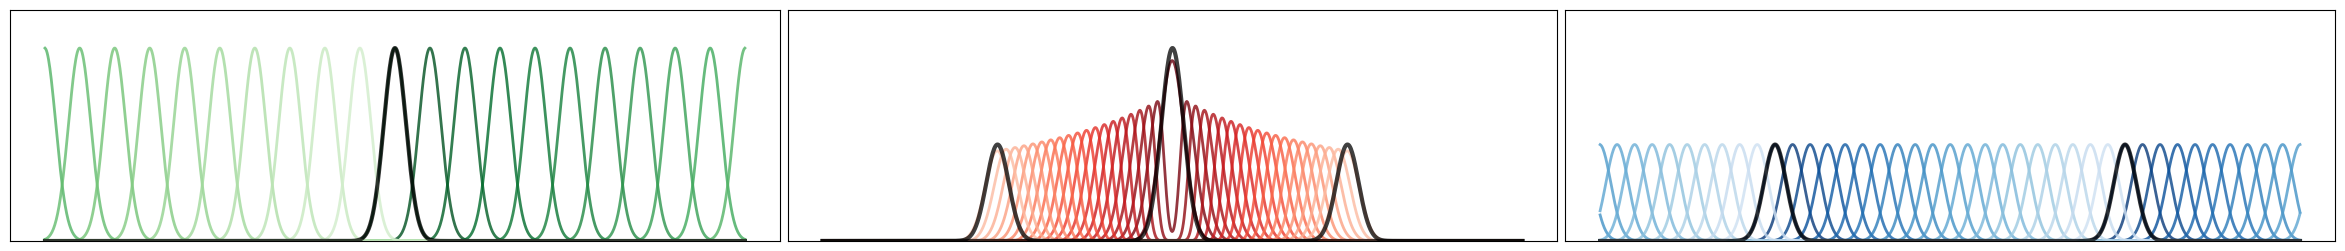

In [11]:
x = np.linspace(-np.pi, np.pi, 1000)
t = np.linspace(0, 1, 1000)

mu = vonmises.pdf(0, 100, x)
mu /= mu.sum()
nu = .5*(vonmises.pdf(np.pi/2, 100,x)+vonmises.pdf(-np.pi/2, 100,x))
nu /= nu.sum()
lcot = LCOT(t)
muhat = lcot.forward(measure([t,mu]))
nuhat = lcot.forward(measure([t,nu]))

K=20

def generate_color_gradient(num_colors,base_color):
    cmap = plt.cm.get_cmap(base_color)
    colors = cmap(np.linspace(1, 0, num_colors))
    return colors

class_colors=[]
class_colors.append(generate_color_gradient(K+5,'Greens'))
class_colors.append(generate_color_gradient(K+5,'Reds'))
class_colors.append(generate_color_gradient(K+5,'Blues'))


fig,ax = plt.subplots(1,3,figsize=(10*3,3))
rs = (np.linspace(0,1000,K+1)[:-1]).astype(int)
measures=[]
alpha = .8*np.ones(K)
for i,r in enumerate(rs):
  temp = np.roll(mu,r)
  measures.append(measure([t,temp]))
  ax[0].plot(t,temp,linewidth=2,c=class_colors[0][i],alpha=alpha[i])

rs = (np.linspace(0,500,K+1)[:-1]).astype(int)
for i,r in enumerate(rs):
  temp = np.roll(nu,r)
  measures.append(measure([t,temp]))
  ax[2].plot(t,temp,linewidth=2,c=class_colors[2][i],alpha=alpha[i])


for i,a in enumerate(np.linspace(0,1,K)):
  nuH = lcot.inverse_kde((1-a)*muhat+a*nuhat,kappa=700)  
  measures.append(nuH)
  ax[1].plot(t,nuH.density_y ,linewidth=2,c=class_colors[1][i],alpha=alpha[i])

ax[0].plot(t,mu,linewidth=3,c='k',alpha=.75)
ax[2].plot(t,nu,linewidth=3,c='k',alpha=.75)
ax[1].plot(t,nu,linewidth=3,c='k',alpha=.75)
ax[1].plot(t,mu,linewidth=3,c='k',alpha=.75)
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_ylim(0,.03)
plt.subplots_adjust(wspace=.01, hspace=0)
plt.show()

In [12]:
#@title # Pairwise distances
lcot = LCOT(t)
mat_lin_COT = np.zeros([len(measures),len(measures)])
mat_COT = np.zeros([len(measures),len(measures)])
mat_OT = np.zeros([len(measures),len(measures)])
mat_euclidean = np.zeros([len(measures),len(measures)])
L = 2500
for i in tqdm(range(len(measures)-1)):
  for j in range(i+1,len(measures)):
    mat_lin_COT[i,j] = lcot.cost(measures[i],measures[j])
    samples_i = measures[i].sample(L)
    samples_j = measures[j].sample(L)
    mat_COT[i,j] = np.sqrt(ot.binary_search_circle(samples_i, samples_j, p=2))
    mat_OT[i,j] = ot_1d(samples_i,samples_j)
    min_sample = min(samples_i.min(), samples_j.min())
    max_sample = max(samples_i.max(), samples_j.max())
    h1, _ = np.histogram(samples_i, bins=360, range=(min_sample, max_sample), density=True)
    h2, _ = np.histogram(samples_j, bins=360, range=(min_sample, max_sample), density=True)
    mat_euclidean[i, j] = (np.sum((h1-h2)**2)/360)**0.5

mat_lin_COT = mat_lin_COT + mat_lin_COT.T
mat_COT = mat_COT + mat_COT.T
mat_OT = mat_OT + mat_OT.T
mat_euclidean = mat_euclidean + mat_euclidean.T


100%|███████████████████████████████████████████| 59/59 [00:28<00:00,  2.08it/s]


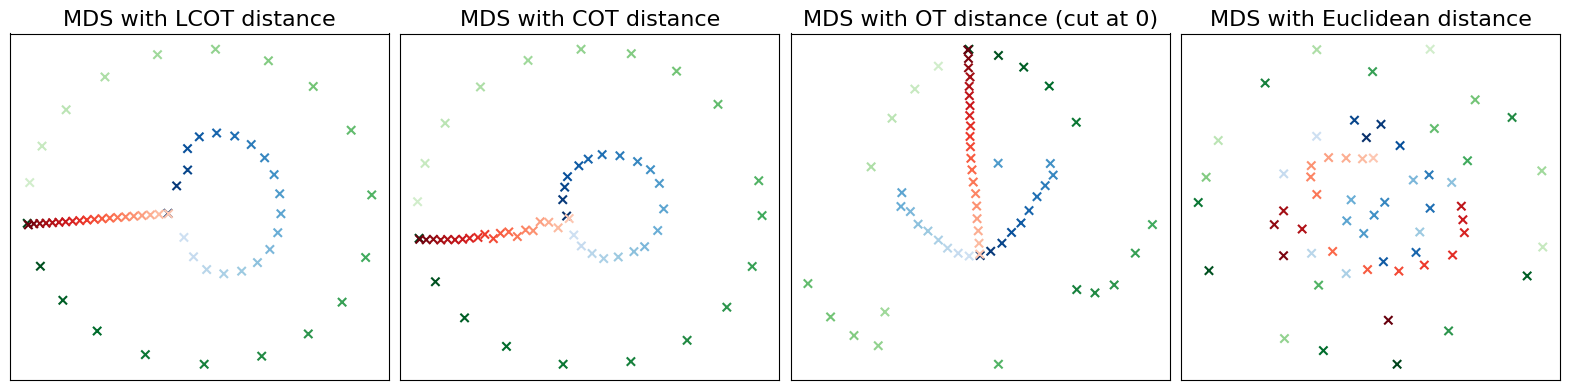

In [13]:
dissimilarity_matrix_LCOT = mat_lin_COT
dissimilarity_matrix_COT = mat_COT
dissimilarity_matrix_OT = mat_OT
dissimilarity_matrix_euclidean = mat_euclidean
len_measures = K
fs = 16
# Create an instance of MDS
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=0)

lower_dimensional_points_LCOT = mds.fit_transform(dissimilarity_matrix_LCOT)
lower_dimensional_points_COT = mds.fit_transform(dissimilarity_matrix_COT)
lower_dimensional_points_OT = mds.fit_transform(dissimilarity_matrix_OT)
lower_dimensional_points_euclidean = mds.fit_transform(dissimilarity_matrix_euclidean)


fig, ax = plt.subplots(1,4, figsize = (4*5,4.5))
# Plot the lower-dimensional points
lower_dimensional_points = lower_dimensional_points_LCOT
ax[0].scatter(lower_dimensional_points[:len_measures, 0], lower_dimensional_points[:len_measures, 1], c=class_colors[0][:K], marker = 'x')
ax[0].scatter(lower_dimensional_points[len_measures:2*len_measures, 0], lower_dimensional_points[len_measures:2*len_measures, 1], c=class_colors[2][:K], marker = 'x',label = '1 Bump')
ax[0].scatter(lower_dimensional_points[2*len_measures:, 0], lower_dimensional_points[2*len_measures:, 1], c=class_colors[1][:K], marker = 'x',label = '2 Bumps')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
ax[0].set_title('MDS with LCOT distance',fontsize=fs)
#plt.axis('square')
#plt.legend()
#plt.show()

lower_dimensional_points = lower_dimensional_points_COT
ax[1].scatter(lower_dimensional_points[:len_measures, 0], lower_dimensional_points[:len_measures, 1], c=class_colors[0][:K], marker = 'x')
ax[1].scatter(lower_dimensional_points[len_measures:2*len_measures, 0], lower_dimensional_points[len_measures:2*len_measures, 1], c=class_colors[2][:K], marker = 'x',label = "1 Bump")
ax[1].scatter(lower_dimensional_points[2*len_measures:, 0], lower_dimensional_points[2*len_measures:, 1], c=class_colors[1][:K], marker = 'x',label = '2 Bumps')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
ax[1].set_title('MDS with COT distance',fontsize=fs)
# plt.axis('square')
# plt.legend()
# plt.show()

lower_dimensional_points = lower_dimensional_points_OT
ax[2].scatter(lower_dimensional_points[:len_measures, 0], lower_dimensional_points[:len_measures, 1], c=class_colors[0][:K], marker = 'x')
ax[2].scatter(lower_dimensional_points[len_measures:2*len_measures, 0], lower_dimensional_points[len_measures:2*len_measures, 1], c=class_colors[2][:K], marker = 'x',label = '1 Bump')
ax[2].scatter(lower_dimensional_points[2*len_measures:, 0], lower_dimensional_points[2*len_measures:, 1], c=class_colors[1][:K], marker = 'x',label = '2 Bumps')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
ax[2].set_title('MDS with OT distance (cut at 0)',fontsize = fs)
# plt.axis('square')
# plt.legend()
# plt.show()

lower_dimensional_points = lower_dimensional_points_euclidean
ax[3].scatter(lower_dimensional_points[:len_measures, 0], lower_dimensional_points[:len_measures, 1], c=class_colors[0][:K], marker = 'x')
ax[3].scatter(lower_dimensional_points[len_measures:2*len_measures, 0], lower_dimensional_points[len_measures:2*len_measures, 1], c=class_colors[2][:K], marker = 'x',label = '1 Bump')
ax[3].scatter(lower_dimensional_points[2*len_measures:, 0], lower_dimensional_points[2*len_measures:, 1], c=class_colors[1][:K], marker = 'x',label = '2 Bumps')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
ax[3].set_title('MDS with Euclidean distance',fontsize= fs)
# plt.axis('square')
# plt.legend()

for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.subplots_adjust(wspace=.03, hspace=0)
plt.show()

## Experiment 2

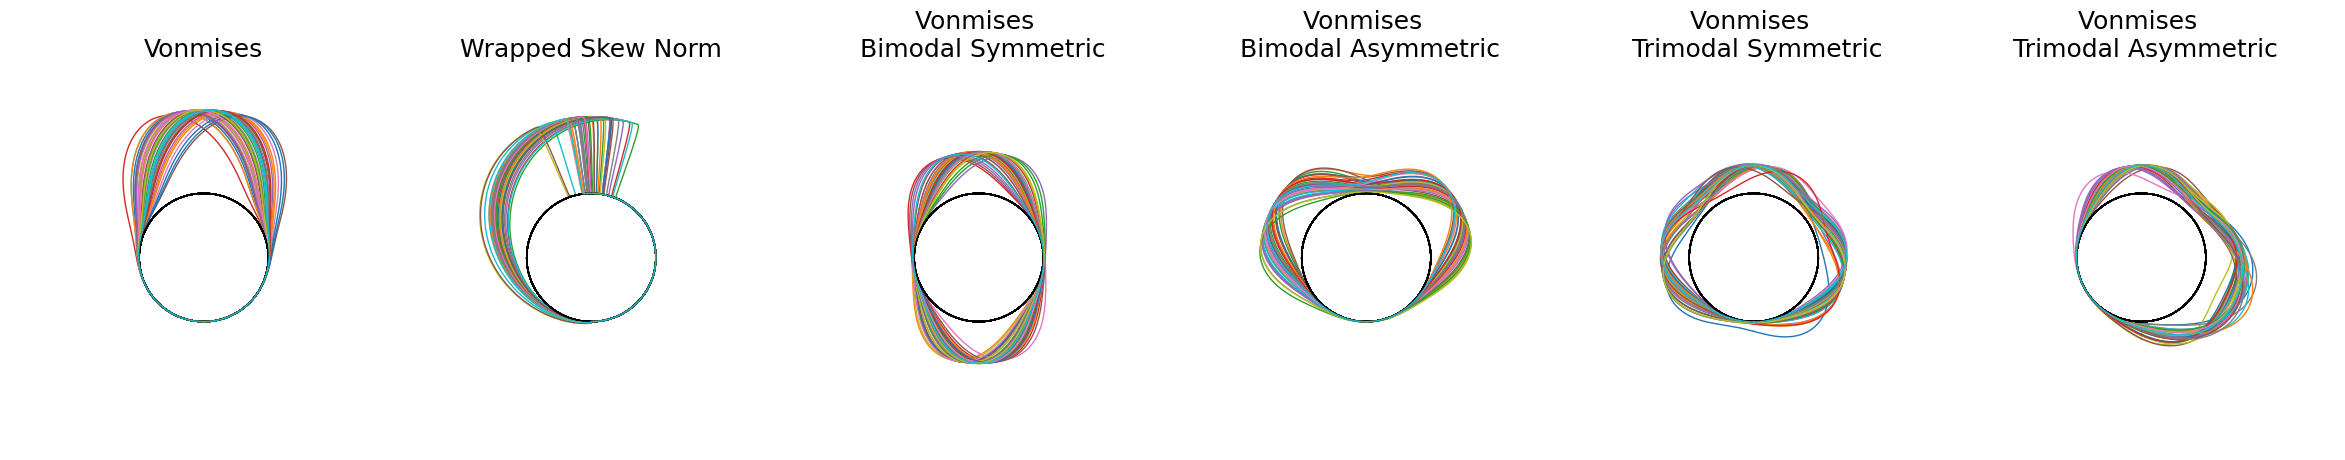

In [14]:
#@title # Generate Densities
np.random.seed(0)
fig , ax = plt.subplots(1,6,figsize=(30,5))
# Minimum and Maximum number of samples
min_ = 50
max_ = 100
# Initialize measures and labels
measures = []
label = []
# Number of measures per class
M = 40
# Parameters of the unimodal von Mises
loc = 0
kappa = 5
scale =.75
kappa_rand = 40
for i in range(M):
  mean_loc = vonmises(loc=0, kappa=kappa_rand).rvs(1)
  pdf = vonmises.pdf(mean_loc+loc, kappa, x)  
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(0)
  plot_circle_pdf(t, pdf,scale=scale, alpha=1,ax=ax[0])

# Parameters of the Skew Norm
a = 100
for i in range(M):
  mean_loc = vonmises(loc=0, kappa=kappa_rand).rvs(1)
  rv = skewnorm(a, loc=mean_loc+loc, scale=1.)
  pdf = rv.pdf(x)
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(1)
  plot_circle_pdf(t,pdf,scale=scale,ax=ax[1])

## Parameters of von Mises bimodal
loc1 = 0
loc2 = np.pi
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(2)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/2
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/2
  pdf = vonmises_1_pdf + vonmises_2_pdf
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(2)
  plot_circle_pdf(t, pdf, scale=scale,alpha=1,ax=ax[2])


## Vonmises bimodal asymmetric
loc1 = +np.pi/3.
loc2 = -np.pi/3.
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(2)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/2
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/2
  pdf = vonmises_1_pdf + vonmises_2_pdf
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(3)
  plot_circle_pdf(t, pdf, alpha=1,scale=scale,ax=ax[3])


## Vonmises trimodal
loc1 = 0
loc2=np.pi/2
loc3=-np.pi*200/360
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(3)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/3
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/3
  vonmises_3_pdf = vonmises.pdf(loc3+mean_locs[2], kappa, x)/3
  pdf = vonmises_1_pdf + vonmises_2_pdf + vonmises_3_pdf  
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(4)
  plot_circle_pdf(t, pdf, scale=scale, alpha=1,ax=ax[4])

## Vonmises trimodal Asymmetric
loc1= 0
loc2=-np.pi/2,
loc3=-np.pi*270/360
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(3)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/3
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/3
  vonmises_3_pdf = vonmises.pdf(loc3+mean_locs[2], kappa, x)/3
  pdf = vonmises_1_pdf + vonmises_2_pdf + vonmises_3_pdf  
  num = np.random.randint(min_, high=max_)
  samples = measure([t,pdf]).sample(num)
  measures.append(empirical_measure(samples))
  label.append(5)
  plot_circle_pdf(t, pdf, scale=scale, alpha=1,ax=ax[5])

label = np.array(label)
titles = [
    'Vonmises','Wrapped Skew Norm',
    'Vonmises \n Bimodal Symmetric','Vonmises \n Bimodal Asymmetric',
    'Vonmises \n Trimodal Symmetric','Vonmises \n Trimodal Asymmetric']
for i in range(6):
    ax[i].axis('off')
    ax[i].set_title(titles[i],fontsize=18)
    ax[i].set_ylim([-1.5,1.5])
    ax[i].set_xlim([-1.5,1.5])
plt.subplots_adjust(wspace=0, hspace=0)

In [15]:
#@title # Pairwise distances
lcot = LCOT(t)
mat_lin_COT = np.zeros([len(measures),len(measures)])
mat_COT = np.zeros([len(measures),len(measures)])
mat_OT = np.zeros([len(measures),len(measures)])
mat_euclidean = np.zeros([len(measures),len(measures)])
for i in tqdm(range(len(measures)-1)):
  for j in range(i+1,len(measures)):
    mat_lin_COT[i,j] = np.sqrt(lcot.cost(measures[i],measures[j]))
    mat_COT[i,j] = np.sqrt(ot.binary_search_circle(measures[i].samples, measures[j].samples, p=2))
    mat_OT[i,j] = ot_1d(measures[i].samples,measures[j].samples)
    min_sample = min(measures[i].samples.min(), measures[j].samples.min())
    max_sample = max(measures[i].samples.max(), measures[j].samples.max())
    h1, _ = np.histogram(measures[i].samples, bins=360, range=(min_sample, max_sample), density=True)
    h2, _ = np.histogram(measures[j].samples, bins=360, range=(min_sample, max_sample), density=True)
    mat_euclidean[i, j] = (np.sum((h1-h2)**2)/360)**0.5

mat_lin_COT = mat_lin_COT + mat_lin_COT.T
mat_COT = mat_COT + mat_COT.T
mat_OT = mat_OT + mat_OT.T
mat_euclidean = mat_euclidean + mat_euclidean.T


100%|█████████████████████████████████████████| 239/239 [01:24<00:00,  2.84it/s]


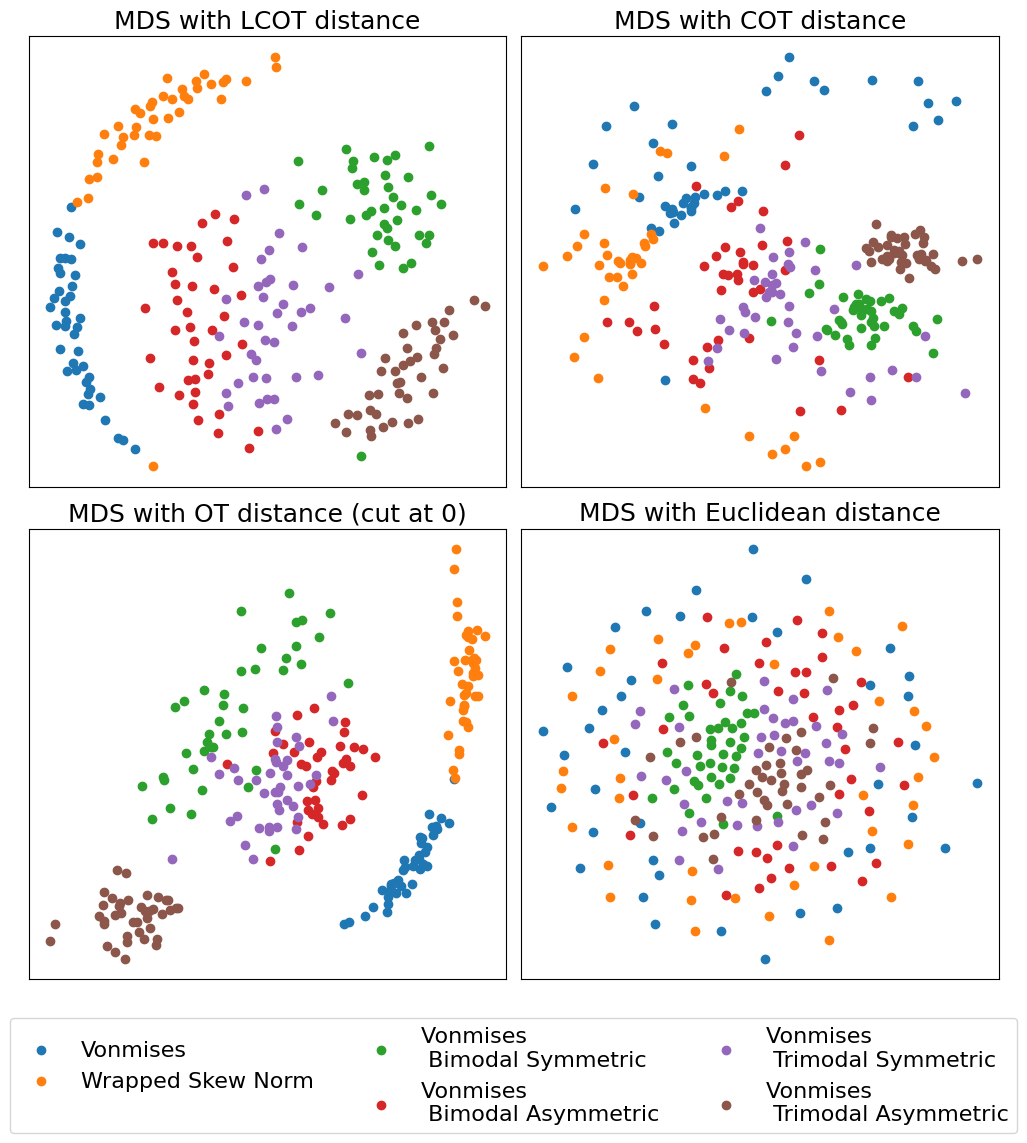

In [16]:
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=1)
lower_dimensional_points_LCOT = mds.fit_transform(mat_lin_COT)
lower_dimensional_points_COT = mds.fit_transform(mat_COT)
lower_dimensional_points_OT = mds.fit_transform(mat_OT)
lower_dimensional_points_euclidean = mds.fit_transform(mat_euclidean)


fig, ax = plt.subplots(2,2, figsize = (10,10))
for i in range(6):
  ax[0,0].scatter(lower_dimensional_points_LCOT[label==i,0], lower_dimensional_points_LCOT[label==i,1], label = titles[i])
  ax[0,0].set_title('MDS with LCOT distance',fontsize=18)
  ax[0,1].scatter(lower_dimensional_points_COT[label==i,0], lower_dimensional_points_COT[label==i,1], label = titles[i])
  ax[0,1].set_title('MDS with COT distance',fontsize=18)
  ax[1,0].scatter(lower_dimensional_points_OT[label==i,0], lower_dimensional_points_OT[label==i,1], label = titles[i])
  ax[1,0].set_title('MDS with OT distance (cut at 0)',fontsize=18)
  ax[1,1].scatter(lower_dimensional_points_euclidean[label==i,0], lower_dimensional_points_euclidean[label==i,1],label = titles[i])
  ax[1,1].set_title('MDS with Euclidean distance',fontsize=18)

for i in range(2):
  for j in range(2):
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
fig.tight_layout()

lines, labels = ax[1,1].get_legend_handles_labels()
fig.legend(lines, labels,loc='lower center',fontsize=16,ncol=3,bbox_to_anchor=(.5,-0.15))

## Experiment 3

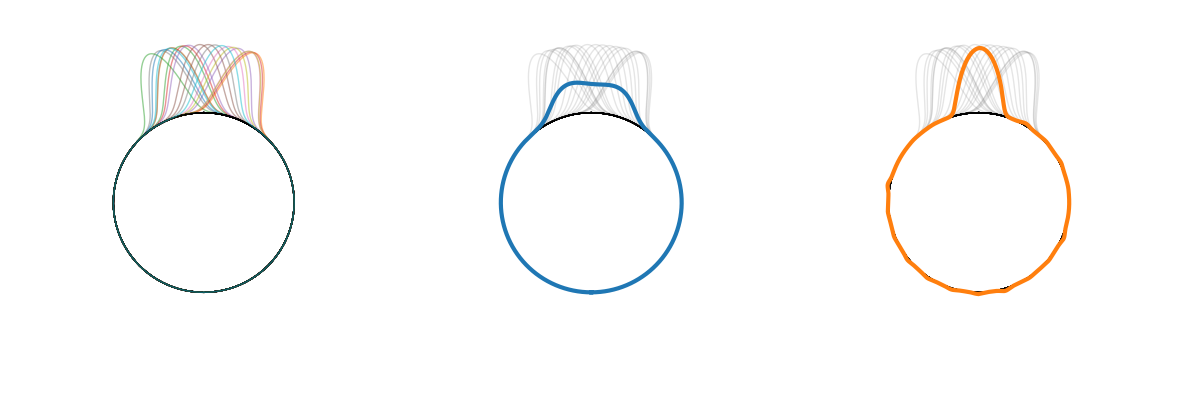

In [27]:
#@title # Generate Densities
np.random.seed(0)
fig , ax = plt.subplots(1,3,figsize=(15,5))
# Initialize measures and labels
measures = []
embeddings = []
# Number of measures per class
M = 20
eps = .7
# Parameters of the unimodal von Mises
loc = 0
kappa = 50
scale =30
kappa_rand = 30
for i in range(M):
  mean_loc = vonmises(loc=0, kappa=kappa_rand).rvs(1)
  pdf = vonmises.pdf(mean_loc+loc, kappa, x)      
  pdf /= pdf.sum()
  nu = measure([t,pdf])
  measures.append(pdf)
  embeddings.append(lcot.forward(nu))
  plot_circle_pdf(t, pdf,ax=ax[0],alpha=.5,c=None,scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[1],alpha=.2,c='gray',scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[2],alpha=.2,c='gray',scale=scale,eps=eps)

Euclidean_barycenter = np.stack(measures,0).mean(0)
plot_circle_pdf(t, Euclidean_barycenter,ax=ax[1],alpha=1.,c='C0',scale=scale,eps=eps,linewidth=3)
embedd_mean = np.stack(embeddings,0).mean(0)
LCOT_barycenter = lcot.inverse_kde(embedd_mean,kappa=500)
lcot_bary = LCOT_barycenter.density_y
tau=3
plot_circle_pdf(t[tau:-tau],lcot_bary[tau:-tau] ,ax=ax[2],alpha=1.,c='C1',scale=scale,eps=eps,linewidth=3)


for m in range(3):
  ax[m].set_yticks([])
  ax[m].set_xticks([])
  ax[m].set_ylim([-1.5,1.5])
  ax[m].set_xlim([-1.5,1.5])
  ax[m].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

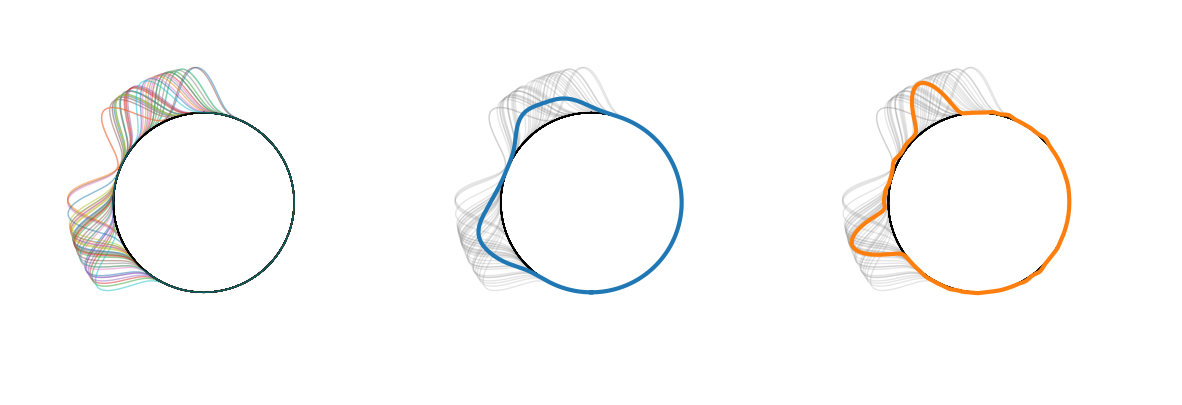

In [31]:
#@title # Generate Densities
np.random.seed(0)
fig , ax = plt.subplots(1,3,figsize=(15,5))
# Initialize measures and labels
measures = []
embeddings = []
scale = 40
M = 30
# Parameters of the unimodal von Mises
loc1 = .15*np.pi
loc2 = .6*np.pi
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(2)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/2
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/2
  pdf = vonmises_1_pdf + vonmises_2_pdf
  pdf /= pdf.sum()
  nu = measure([t,pdf])
  measures.append(pdf)
  embeddings.append(lcot.forward(nu))
  plot_circle_pdf(t, pdf,ax=ax[0],alpha=.5,c=None,scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[1],alpha=.2,c='gray',scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[2],alpha=.2,c='gray',scale=scale,eps=eps)

Euclidean_barycenter = np.stack(measures,0).mean(0)
plot_circle_pdf(t, Euclidean_barycenter,ax=ax[1],alpha=1.,c='C0',scale=scale,eps=eps,linewidth=3)
embedd_mean = np.stack(embeddings,0).mean(0)
LCOT_barycenter = lcot.inverse_kde(embedd_mean,kappa=500)
lcot_bary = LCOT_barycenter.density_y
tau=3
plot_circle_pdf(t[tau:-tau],lcot_bary[tau:-tau] ,ax=ax[2],alpha=1.,c='C1',scale=scale,eps=eps,linewidth=3)


for m in range(3):
  ax[m].set_yticks([])
  ax[m].set_xticks([])
  ax[m].set_ylim([-1.5,1.5])
  ax[m].set_xlim([-1.5,1.5])
  ax[m].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)

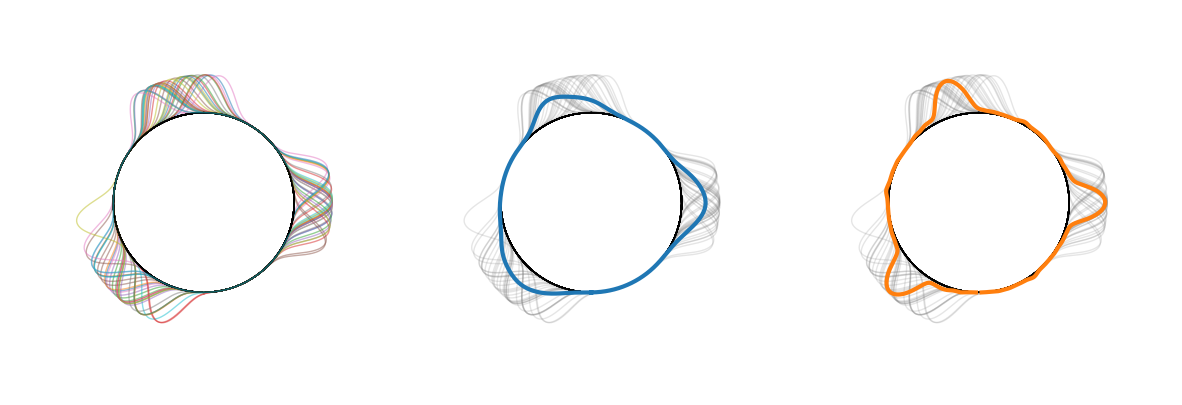

In [37]:
#@title # Generate Densities
np.random.seed(1)
fig , ax = plt.subplots(1,3,figsize=(15,5))
# Initialize measures and labels
measures = []
embeddings = []
# Number of measures per class
M = 30
eps = .7
scale = 50
# Parameters of the unimodal von Mises
## Vonmises trimodal Asymmetric
loc1= .1*np.pi
loc2=-.5*np.pi
loc3=.75*np.pi
for i in range(M):
  mean_locs = vonmises(loc=0, kappa=kappa_rand).rvs(3)
  vonmises_1_pdf = vonmises.pdf(loc1+mean_locs[0], kappa, x)/3
  vonmises_2_pdf = vonmises.pdf(loc2+mean_locs[1], kappa, x)/3
  vonmises_3_pdf = vonmises.pdf(loc3+mean_locs[2], kappa, x)/3
  pdf = vonmises_1_pdf + vonmises_2_pdf + vonmises_3_pdf  
  pdf /= pdf.sum()
  nu = measure([t,pdf])
  measures.append(pdf)
  embeddings.append(lcot.forward(nu))
  plot_circle_pdf(t, pdf,ax=ax[0],alpha=.5,c=None,scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[1],alpha=.2,c='gray',scale=scale,eps=eps)
  plot_circle_pdf(t, pdf,ax=ax[2],alpha=.2,c='gray',scale=scale,eps=eps)

Euclidean_barycenter = np.stack(measures,0).mean(0)
plot_circle_pdf(t, Euclidean_barycenter,ax=ax[1],alpha=1.,c='C0',scale=scale,eps=eps,linewidth=3)
embedd_mean = np.stack(embeddings,0).mean(0)
LCOT_barycenter = lcot.inverse_kde(embedd_mean,kappa=500)
lcot_bary = LCOT_barycenter.density_y
tau=5
plot_circle_pdf(t[tau:-tau],lcot_bary[tau:-tau] ,ax=ax[2],alpha=1.,c='C1',scale=scale,eps=eps,linewidth=3)


for m in range(3):
  ax[m].set_yticks([])
  ax[m].set_xticks([])
  ax[m].set_ylim([-1.5,1.5])
  ax[m].set_xlim([-1.5,1.5])
  ax[m].axis('off')
plt.subplots_adjust(wspace=0, hspace=0)